In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


In [2]:
from importlib import reload
import numpy as np
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm, trange
import mmcv
import data
import bbox
from utils import imshownp
import meva
from meva.lib.meva_model import MEVA
from meva.utils import kp_utils
from meva.utils import image_utils
from meva.utils.video_config import update_cfg
from torch.utils.data import DataLoader
import joblib

/home/tormod/Documents/APEC/meva/utils/transformations.py:1927: UserWarning: No module named 'meva.utils._transformations'
  warnings.warn(str(err))


In [3]:
from importlib import reload
reload(data)

<module 'data' from '/home/tormod/Documents/APEC/data.py'>

In [4]:
c = data.ClimbingDataset('test', preload_all=True)

In [9]:
pretrained_file = f"results/meva/train_meva_2/model_best.pth.tar"
config_file = f"meva/cfg/train_meva_2.yml"
cfg = update_cfg(config_file)

In [8]:
batch_size = 6
model = MEVA(
    n_layers=cfg.MODEL.TGRU.NUM_LAYERS,
    batch_size=batch_size,
    seqlen=cfg.DATASET.SEQLEN,
    hidden_size=cfg.MODEL.TGRU.HIDDEN_SIZE,
    add_linear=cfg.MODEL.TGRU.ADD_LINEAR,
    bidirectional=cfg.MODEL.TGRU.BIDIRECTIONAL,
    use_residual=cfg.MODEL.TGRU.RESIDUAL,
    cfg=cfg.VAE_CFG,
)
ckpt = torch.load(pretrained_file, map_location='cpu')
# print(f'Performance of pretrained model on 3DPW: {ckpt["performance"]}')
ckpt = ckpt['gen_state_dict']
model.load_state_dict(ckpt)
model.eval()

loading VAErecV2 model from checkpoint: results/meva/vae_rec_2/models/model_1000.p


MEVA(
  (vae_model): VAErecV2(
    (e_rnn): RNN(
      (rnn_f): GRUCell(144, 256)
      (rnn_b): GRUCell(144, 256)
    )
    (e_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (e_mu): Linear(in_features=512, out_features=512, bias=True)
    (e_logvar): Linear(in_features=512, out_features=512, bias=True)
    (d_rnn): RNN(
      (rnn_f): GRUCell(656, 512)
    )
    (d_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (d_out): Linear(in_features=512, out_features=144, bias=True)
    (init_pose_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (init_p

In [24]:
batch_size=6
dataloader = DataLoader(c, batch_size=batch_size, num_workers=2, shuffle = False)

In [25]:
for i in tqdm(iter(dataloader)):
    print(i)

{'raw_imgs': [], 'norm_imgs': [], 'features': tensor([[[1.6733e-02, 4.3175e-02, 2.8234e-03,  ..., 2.0823e-03,
          0.0000e+00, 1.8785e-04],
         [1.4970e-02, 4.5376e-02, 3.1148e-03,  ..., 1.9765e-03,
          3.4148e-04, 2.4862e-04],
         [1.5634e-02, 4.2915e-02, 3.0696e-03,  ..., 2.0345e-03,
          5.2578e-04, 0.0000e+00],
         ...,
         [2.0071e-02, 1.9764e-02, 4.2988e-04,  ..., 7.5248e-03,
          0.0000e+00, 1.9939e-03],
         [3.4095e-02, 2.0067e-02, 3.6352e-05,  ..., 7.3496e-03,
          0.0000e+00, 2.8970e-03],
         [3.2251e-02, 1.3399e-02, 1.7295e-03,  ..., 8.4160e-03,
          0.0000e+00, 1.8276e-03]],

        [[2.6349e-02, 2.0487e-02, 9.7649e-04,  ..., 9.2827e-03,
          0.0000e+00, 1.6464e-03],
         [3.0360e-02, 1.8265e-02, 2.1661e-03,  ..., 8.4840e-03,
          0.0000e+00, 1.3764e-03],
         [3.1592e-02, 1.8425e-02, 2.1736e-03,  ..., 1.0481e-02,
          0.0000e+00, 1.0049e-03],
         ...,
         [7.9041e-03, 5.6730e-02,

In [36]:
import time
output = {}
pred_cam, pred_verts, pred_pose, pred_betas, pred_joints3d, norm_joints2d = [], [], [], [], [], []
for seqs in dataloader.batch_sampler:
    with torch.no_grad():
        start = time.time()
        feats = torch.stack([torch.Tensor(seq['features']) for seq in seqs])
        output = model(feats)[-1]
        finish = time.time()
        pred_cam.append(output['theta'][:, :, :3])
        pred_verts.append(output['verts'])
        pred_pose.append(output['theta'][:, :, 3:75])
        pred_betas.append(output['theta'][:, :, 75:])
        pred_joints3d.append(output['kp_3d'])
        norm_joints2d.append(output['kp_2d'])
    break
pred_cam = torch.cat(pred_cam, dim=0)
pred_verts = torch.cat(pred_verts, dim=0)
pred_pose = torch.cat(pred_pose, dim=0)
pred_betas = torch.cat(pred_betas, dim=0)
pred_joints3d = torch.cat(pred_joints3d, dim=0)
norm_joints2d = torch.cat(norm_joints2d, dim=0)

pred_cam = pred_cam.cpu().numpy()
pred_verts = pred_verts.cpu().numpy()
pred_pose = pred_pose.cpu().numpy()
pred_betas = pred_betas.cpu().numpy()
pred_joints3d = pred_joints3d.cpu().numpy()
norm_joints2d = norm_joints2d.cpu().numpy()
output_dict = {'pred_cam': pred_cam,
               'verts': pred_verts,
               'pose': pred_pose,
               'betas': pred_betas,
               'joints3d': pred_joints3d,
               'joints2d': norm_joints2d}

In [74]:
(finish-start)*len(c)/batch_size

2.7524242401123047

In [38]:
norm_joints2d.shape

(6, 90, 49, 2)

In [38]:
seqidx = 2
frameid = 20
seqinfo = c.get(seqidx)

/home/tormod/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


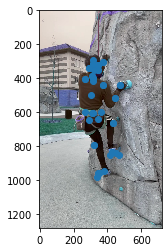

In [39]:
inv_trans = seqinfo['inv_trans'][frameid].copy()
kp_2d = norm_joints2d[seqidx, frameid].copy()
kp_2d *= 1.2
kp_2d = image_utils.normalize_2d_kp(kp_2d, inv=True)
kp_2d = image_utils.trans_points2d(kp_2d, inv_trans)
plt.imshow(seqinfo['raw_imgs'][frameid])
plt.scatter(kp_2d[:,0], kp_2d[:,1])
plt.show();

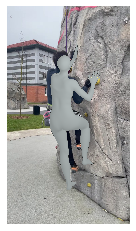

In [43]:
import mesh
verts = pred_verts[seqidx, frameid].copy()
cam = pred_cam[seqidx, frameid].copy()
bboxes = seqinfo['bboxes'].copy()
img = seqinfo['raw_imgs'][frameid].copy()
cam[0] *= 1.2*1.2
imshownp(mesh.render_pred_mesh(img, bboxes, verts, cam), bgr=True)

In [27]:
res = joblib.load('/home/tormod/ucph-erda-home/meva_results/meva_output.pkl')
pred_cam = res['pred_cam']
pred_verts = res['verts']
pred_pose = res['pose']
pred_betas = res['betas']
pred_joints3d = res['joints3d']
norm_joints2d = res['joints2d']

In [ ]:
norm_joints2d.shape

In [9]:
import mesh
reload(mesh)
mesh.render_vids(c, res, '/media/tormod/Den Lille/Thesis/meva_out/test')

IMG_2139 ...



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3240/3240, 28.3 task/s, elapsed: 114s, ETA:     0s
